<a href="https://colab.research.google.com/github/lucia1299/TheCrabTeam/blob/main/flights_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install powerlaw
import powerlaw

In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as st

In [3]:
G = nx.read_graphml("/content/final_flights.graphml")

## **Preliminary Steps**

# Remove isolated nodes

When approeaching the calculation of the degree of distrubtion, it was clear to us that there were some isolated nodes in the graph that escaped the data cleaning phase, according to which all passengers travelling alone were going to be excluded from the analysis. Therefore, the isolated nodes have been removed from the graph before performing all the analysis below.

In [4]:
#If a node has a degree of 0, it means that there are no edges connected to it
degree_distribution = dict(nx.degree(G))

# Determine the minimum and maximum degree in the graph
min_degree = min(degree_distribution.values())

# Count the occurrences of the minimum degree
min_degree_count = list(degree_distribution.values()).count(min_degree)

print("Minimum degree:", min_degree)
print("Number of occurrences:", min_degree_count)

Minimum degree: 0
Number of occurrences: 13


After cross checking with the original database whether the nodes were actually isolated, they were removed from the graph G.

In [5]:
isolated_nodes = list(nx.isolates(G))
print(isolated_nodes)

['300', '228', '288', '225', '159', '224', '600', '299', '298', '433', '227', '226', '428']


In [6]:
G.remove_nodes_from(isolated_nodes)

# Remove self-loops

Another aspect that emerged when performing calculations was the existence of self loops, that escaped the data cleaning phase because the same person was cited twice as a passenger in the same plane. We initially did not remove these duplicates to avoid removing people that might have also been simply different people (indeed, we do not have in any case the full name but only the initials).

In [7]:
self_edges = list(nx.selfloop_edges(G, keys=True, data=True))
self_edges

[('437',
  '437',
  {'weight': 1.0,
   'source_name': 'LM',
   'target_name': 'LM',
   'metadata_1': "['256.0']",
   'metadata_2': "['256.0']",
   'id': '5759'}),
 ('477',
  '477',
  {'weight': 1.0,
   'source_name': 'NM',
   'target_name': 'NM',
   'metadata_1': "['352.0']",
   'metadata_2': "['352.0']",
   'id': '6008'}),
 ('325',
  '325',
  {'weight': 1.0,
   'source_name': 'SK',
   'target_name': 'SK',
   'metadata_1': "['352.0']",
   'metadata_2': "['352.0']",
   'id': '5128'})]

In [8]:
self_edges = list(nx.selfloop_edges(G))
for u, v in self_edges:
    G.remove_edge(u, v)
self_edges

[('437', '437'), ('477', '477'), ('325', '325')]

At this point we make sure to assign the name to all nodes so that we can easily print that out when performing the analysis

In [9]:
node_name = nx.get_node_attributes(G, "name")

## **Centrality measures**

## Degree Centrality

Degree Centrality: Reflects the number of connections a node has. "JE" (Jeffrey Epstein) has the highest degree centrality, implying that this person has the most direct connections. "GM" and "SK" (Ghislaine Maxwell and Sarah Kellen) also denote a significantly higher degree centrality in comparison to the other nodes, highlighting their relevance in the network.

In [10]:
degree_centrality = nx.degree_centrality(G)
dc_data = pd.DataFrame({"Id": list(degree_centrality.keys()),
                        "Name": [node_name[node] for node in degree_centrality.keys()],
                        "DegreeCentrality": list(degree_centrality.values())
                        }).sort_values(by="DegreeCentrality", ascending=False).reset_index(drop=True)

dc_data.head(10)

,Id,Name,DegreeCentrality
0,0,JE,0.881557
1,4,GM,0.573604
2,325,SK,0.353638
3,128,ET,0.216582
4,185,AP,0.189509
5,479,LV,0.172589
6,477,NM,0.157360
7,437,LM,0.133672
8,410,AM,0.113367
9,438,BT,0.106599


# Betweenness Centrality

This measure investigates the extent to which a
node lies on paths between other nodes. High values suggest that the node plays a critical role in connecting other nodes in the network. As expected, "JE" (Jeffrey Epstein) has the highest betweenness centrality, indicating that this individual's presence is crucial for maintaining connectivity between other nodes. "GM" (Ghislaine Maxwell) also has high values compared to the other nodes, highlighting the possibility of her being relevant to the contribution to the existence of the network.

In [11]:
weighted_betweenness_centrality = nx.betweenness_centrality(G, weight="weight")

wbc_data = pd.DataFrame({"Id": list(weighted_betweenness_centrality.keys()),
                        "Name": [node_name[node] for node in weighted_betweenness_centrality.keys()],
                        "WeightedBetweennessCentrality": list(weighted_betweenness_centrality.values())
                        }).sort_values(by="WeightedBetweennessCentrality", ascending=False).reset_index(drop=True)

wbc_data.head(10)

,Id,Name,WeightedBetweennessCentrality
0,0,JE,0.462031
1,4,GM,0.224532
2,325,SK,0.061051
3,479,LV,0.057520
4,128,ET,0.047022
5,185,AP,0.035379
6,410,AM,0.026653
7,409,CD,0.022656
8,437,LM,0.020913
9,438,BT,0.017153


# Closeness Centrality

Weighted closeness centrality gauges a node's ability to efficiently connect with others in the network, factoring in the importance of the edges. It analysis the extent to which a node is close to other nodes in a network.

Nodes boasting higher weighted closeness centrality are pivotal in facilitating communication and information dissemination within the network due to their strong connections and consideration of edge weights. The first ten people have closeness centrality values that are quite close to each other, suggesting that extent to which this network is entagled.

Note: in this specific database, we decided to leave together the nodes that represent two people (i.e. JORDAN+NANNY DUBIN) because in the context of investigating whether two people knew each other on the basis of whether they flew together, we concluded that people represented as members of the same family (with the same surname) necessarily knew each other.

In [12]:
weighted_closeness_centrality = nx.closeness_centrality(G, distance="weight")

wcc_data = pd.DataFrame({"Id": list(weighted_closeness_centrality.keys()),
                        "Name": [node_name[node] for node in weighted_closeness_centrality.keys()],
                        "WeightedClosenessCentrality": list(weighted_closeness_centrality.values())
                        }).sort_values(by="WeightedClosenessCentrality", ascending=False).reset_index(drop=True)

wcc_data.head(10)

,Id,Name,WeightedClosenessCentrality
0,0,JE,0.545963
1,4,GM,0.459095
2,221,JORDAN + NANNY DUBIN,0.412497
3,491,TAMI,0.411908
4,509,CELINA + MYA DUBIN,0.409860
5,472,MORGAN,0.408121
6,492,ARIANE DE BONVOISIN,0.405825
7,337,GEOF TINTRY,0.404686
8,177,RON,0.404403
9,488,NINA KEITA,0.403837


# Eigenvector Centrality

Weighted eigenvector centrality assesses the importance of a node in a network, considering both the network topology and the weights of its connections (which corresponds to the number of flights taken with people within the network). In short, it considers the number of connections and how important are the neighbours of a node. As expected, the most central node is "JE" (Jeffrey Epstein). However, it is interesting to analyse the relevance of other nodes to the network, namely "GM" (Ghilsaine Maxwell"), "SK" (Sarah Kellen) and "ET" (Emmy Tayler).


In [13]:
weighted_eigenvector_centrality = nx.eigenvector_centrality(G, weight="weight")

wec_data = pd.DataFrame({"Id": list(weighted_eigenvector_centrality.keys()),
                        "Name": [node_name[node] for node in weighted_eigenvector_centrality.keys()],
                        "WeightedEigenvectorCentrality": list(weighted_eigenvector_centrality.values())
                        }).sort_values(by="WeightedEigenvectorCentrality", ascending=False).reset_index(drop=True)

wec_data.head(10)

,Id,Name,WeightedEigenvectorCentrality
0,0,JE,0.615505
1,4,GM,0.490310
2,325,SK,0.381242
3,128,ET,0.238509
4,477,NM,0.207544
5,479,LV,0.206007
6,437,LM,0.142053
7,185,AP,0.141919
8,438,BT,0.081304
9,458,TD,0.078218


## **Structural Analysis**

# Small Worldness

The concept of small-world-ness in network theory refers to the phenomenon where most nodes in a network can be reached from every other node by a small number of steps.

A network is considered a small-world network if it has:

*   A high clustering coefficient (C in this code): This means that nodes in the network tend to create tightly knit groups characterized by a relatively high density of ties.
*   A small average shortest path length (L in this code): This means that the average number of steps along the shortest paths for all possible pairs of network nodes is minimized.

When calculating Omega to understand whether the network in question is a small-world network, it is to be noted that the Omega value ranges from -1 to 1. A positive Omega value indicates that the network is more like a random graph, while a negative Omega value indicates that the network is more like a lattice graph. An Omega value close to zero suggests that the network exhibits small-world properties. This is the case of the Flights Logs network, highlighting its small-world aspect.


In [14]:
C = nx.average_clustering(G)
equivalent_random_graph = nx.erdos_renyi_graph(G.number_of_nodes(), p=np.mean([d for _, d in G.degree()]) / (nx.number_of_nodes(G) - 1))
L_random = nx.average_shortest_path_length(equivalent_random_graph)
random_lattice_graph = nx.lattice_reference(nx.watts_strogatz_graph(G.number_of_nodes(), k=4, p=0))

L_list = [nx.average_shortest_path_length(G.subgraph(n).copy()) for n in nx.connected_components(G)]

if len(L_list) > 1:
    computable_L_list = [L for L in L_list if L != 1.0]
    if len(computable_L_list) == 1:
        L = computable_L_list[0]
    else:
        L = st.mean(computable_L_list)
else:
    L = L_list[0]

omega = ((L_random / L) - (C / nx.average_clustering(random_lattice_graph)))

print("C = ", C)
print("Cl = ", nx.average_clustering(random_lattice_graph))
print("L = ", L)
print("Lr = ", L_random)

print("Omega = ", omega)

C =  0.8082340024163069
Cl =  0.5
L =  2.1481149748273034
Lr =  2.9896476425664242
Omega =  -0.22471398905569973


# Degree of distribution



A node’s degree refers to the count of its connections with other nodes. The degree distribution is a measure that shows the likelihood of each degree across the entire network. In the majority of real-world networks, the degree distribution is notably skewed. This means that a large portion of nodes  have a low degree, while a smaller, but still significant group of nodes possess an exceptionally high degree. The result of our analysis prove the network around Jeffrey Epstein to be a real-world network.

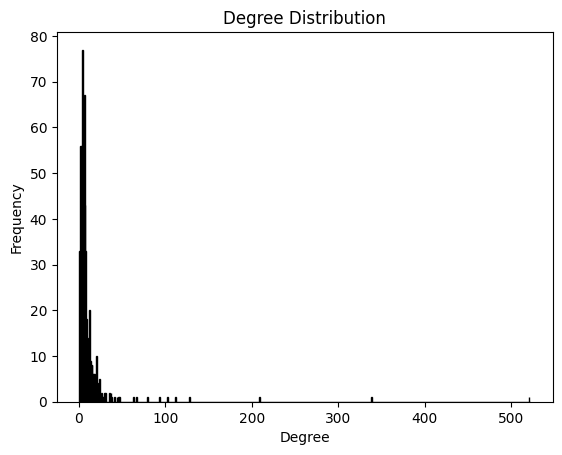

In [15]:
degree_distribution = dict(nx.degree(G))

max_degree = max(degree_distribution.values())
min_degree = min(degree_distribution.values())

plt.hist(degree_distribution.values(), bins=max_degree+1, range=(min_degree, max_degree+1), color='skyblue', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution')
plt.show()

Since this pattern suggests that the Flights Logs network is a scale-free network, in which most nodes are poorly connected, and only a few nodes (called hubs) are highly connected. Because of this, we decided to calculate the alpha value for this network. If it is less than 2, it indicates that there are a few nodes with a very high degree, which is characteristic of scale-free networks. If the alpha value is greater than 2, it suggests that the degrees of the nodes are more evenly distributed.

In [16]:
degree_distribution_list = [G.degree(node) for node in G]

shifted_degree_distribution_list = [degree for degree in degree_distribution_list]

shifted_degree_distribution_list = [max(0, degree) for degree in shifted_degree_distribution_list]

n = len(shifted_degree_distribution_list)
sum_val = sum(np.log(degree) for degree in shifted_degree_distribution_list)

alpha = 1 + n * (sum_val ** -1)
print("Alpha =", alpha)

Alpha = 1.5665436494047218


## **Other measurements**

# Compactness

Compactness in a network refers to the efficiency of information flow, indicating how closely connected nodes are to each other by taking into consideration the weights of the edges connecting them.

To perform compactness, it was also interesting to build a subgraph in which the most central nodes ("JE" and "GM") are excluded. It is interesting to notice that the overall compactness necessarily changes, but not as significantly as expected (from 0.36 to 0.30).

In [17]:
# List of nodes to exclude
exclude_nodes = ['0', '4']

# Creation of a subgraph excluding the specified nodes
subgraph_nodes = [node for node in G.nodes() if node not in exclude_nodes]
subgraph = G.subgraph(subgraph_nodes)

In [18]:
def calc_compactness(graph):
    shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(graph, weight='weight'))

    total_compactness = 0
    total_pairs = 0

    for source, lengths in shortest_path_lengths.items():
        for target, distance in lengths.items():
            if source != target:
                total_compactness += 1 / distance
                total_pairs += 1

    if total_pairs == 0:
        return 0

    return total_compactness / total_pairs

compactness_all = calc_compactness(G)
print("Compactness of the network : ", compactness_all)

compactness_noJEGM = calc_compactness(subgraph)
print("Compactness of the network without considering Jeffrey Esptein and Ghislaine Maxwell: ", compactness_noJEGM)

Compactness of the network :  0.36805375217247877
Compactness of the network without considering Jeffrey Esptein and Ghislaine Maxwell:  0.30568921779233665


## **Clustering**

# Clustering for each node

The weighted clustering coefficient measures the tendency of nodes in a network to form clusters or groups, taking into account the strengths of connections. Like the average clustering coefficient (see below), it measures the tendency for nodes to form clusters with their neighbors. However, it also considers edge weights, which might represent strengths or frequencies of connections between nodes.

In [19]:
clustering = nx.clustering(G, weight="weight")

clustering_data = pd.DataFrame({"Id": list(clustering.keys()),
                        "Name": [node_name[node] for node in clustering.keys()],
                        "Clustering": list(clustering.values())
                        }).sort_values(by="Clustering", ascending=False).reset_index(drop=True)

clustering_data.head(10)

,Id,Name,Clustering
0,36,KATHERINA KOTZIG,0.033558
1,14,SHARON REYNOLDS,0.025610
2,517,PIA TRUSELL,0.022365
3,248,CLARE HAZEL,0.020719
4,238,AUDREY RAIMBAULT,0.019973
5,237,SHELLY HARRISON,0.018282
6,178,ADAM PERRY LANG,0.017705
7,261,CHERI KRAPE,0.017065
8,430,PATRICK OCHIN,0.016564
9,318,BANU KUCUKOGLU,0.016133


# Transitivity

Transitivity in a network measures the likelihood that two nodes connected to the same node are also connected to each other. Therefore, it calculates the ratio of closed triangles to all possible triangles in the graph, providing insight into the global clustering structure of the graph. In this case, the transitivity value is quite low (i.e. 0.089) and it highlights the fact that it is not likely that two nodes connected to the same node are also connected to each other.

In [20]:
transitivity = nx.transitivity(G)
print("Transitivity: ", transitivity)

Transitivity:  0.08972959554327312


# Average Clustering Coefficient

This measure calculates the degree of clustering around individual nodes, averaged over all nodes in the graph. The value shows that the graph has a high level of clustering at the local level but a relatively low level of global clustering. There is a high tendency of forming clusters with their neighbours, but when looking at the transitivity level one can notice that the connections between different local clusters are relatively sparse.

In [21]:
average_clustering = nx.average_clustering(G)
average_clustering

0.8082340024163069

## **Groups of nodes**

# Cliques: K-core

The nodes that lie within the highest-k cores are “core” nodes within the network, while nodes outside those cores are "peripheral" to the network. The K-core decomposition results in core numbers ranging from 0 to 16. Higher core numbers indicate nodes with increased connectivity within the core structure, highlighting their importance in maintaining network integrity. It is interesting to notice that the most connected nodes are not necessarily the ones that have the highest Kcore. That happens because a node with a high degree has many neighbors, while a node with a high k-core number is part of a dense neighborhood. Indeed, a node might have a high degree but a low k-core number if it’s connected to many nodes that are not well connected themselves. Conversely, a node might have a high k-core number but a relatively low degree if its connections are mostly to other well-connected nodes.

In [22]:
core_number = nx.core_number(G)
k_data = pd.DataFrame({"Id": list(core_number.keys()),
                        "Name": [node_name[node] for node in clustering.keys()],
                        "KCore": list(core_number.values())
                        }).sort_values(by="KCore", ascending=False).reset_index(drop=True)

k_data

,Id,Name,KCore
0,405,RON BURKLE,16
1,404,CASEY+LAURA WASSERMAN,16
2,395,PRESIDENT WILLIAM J. CLINTON,16
3,338,CHAUNTAE DAVIES,16
4,402,ERIC NONNES,16
...,...,...,...
587,328,BONNIE,1
588,190,JEAN LUKE,1
589,242,SHELLY ANNE LEWIS,1
590,305,CAROL,1
